# South African Language Identification Hack 2022

## Overview

South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society.

The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages.

**The Challenge**: Take text which is in any of South Africa's 11 Official languages and identify which language the text is in.

**Evaluation**: The evaluation metric for this competition is Mean F1-Score.

**Solution presented by**: Martha Mwaura

## Table of Contents

## 1. Importing Packages

For purposes of **data loading, analysis and visualization**, the following libraries will be imported and used:
- `pandas`: It offers data structures and operations for manipulating numerical tables and time series.
- `matplotlib`: It is a plotting library that provides an object-oriented API for embedding plots into applications.
- `wordcloud`: It is a text data visualization library in which the size of each word indicates its frequency.

For purposes of **data cleaning and preprocessing**, the following libraries will be imported and used:
- `re`: It contains functions that let one check if a particular string matches a given regular expression.
- `sklearn`: It provides a selection of efficient tools for machine learning and statistical modeling including classification, regression, clustering and dimensionality reduction.

For purposes of **code evaluation**, the following libraries will be imported and used:
- `time`: It provides many ways of representing time in code.

In [52]:
# Libraries for data loading, analysis and visualization
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from wordcloud import WordCloud

# Libraries for data cleaning and preprocessing
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries for Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Libraries for evaluation
import time
from sklearn import metrics

## 2. Loading the Data

The data provided, `sample_submission.csv`, `test_set.csv`, and `train_set.csv` will be loaded into dataframes with the help of the pandas' `read_csv`method.

In [4]:
# Load the train,test, and sample submission data
df_train = pd.read_csv('train_set.csv')
df_test = pd.read_csv('test_set.csv')
df_sample_submission = pd.read_csv('sample_submission.csv')

#View a random sample of the loaded data
display(df_train.sample(3))
display(df_test.sample(3))
display(df_sample_submission.sample())

lang_id                                               text
15389     sot  dipitso o ne a tshwara dipitso ho hlahisa setj...
12966     ven  nga ḓuvha heḽi ḽo khetheaho ri tea u dovha ra ...
3663      ssw  emalunga elikomiti atawugcina bufinhlo kuwo on...

index                                               text
3707   3708  Ku pima mfanelo ya nwana ya dyondzo ya masungu...
1515   1516  nokwamkelwa kohlahlomali lwewexeshana okanye k...
3912   3913               mo go Tlaleletso C ya Mametlelelo e.

index lang_id
0      1     tsn

From the samples above, the data has been loaded successfully.

## 3. Exploratory Data Analysis (EDA)

From the samples generated after loading the data, the `train` dataset has 2 columns: `lang_id` and `text`. The `holdout` dataset has 2 columns as well: `index` and `text`. The submission file should also have 2 columns: `index` and `lang_id`.

The next step is to check the datatypes of the respective columns and check if there are null values in the dataset.

In [5]:
# Datatype for each column
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


The `train` dataset has a total of 33,000 records and all are non-null of type **object**.

Since the goal is to classify the text in the holdout dataset into its respective language, find out the `lang_id` present in the dataset.

In [6]:
# Get the unique lang_id
languages = df_train['lang_id'].unique()
languages

array(['xho', 'eng', 'nso', 'ven', 'tsn', 'nbl', 'zul', 'ssw', 'tso',
       'sot', 'afr'], dtype=object)

The languages represented by the language ids are:
- **xho**: isoXhosa
- **eng**: English
- **nso**: Sepedi
- **ven**: Tshivenda
- **tsn**: Setswana
- **nbl**: isiNdebele
- **zul**: isiZulu
- **ssw**: siSwati
- **tso**: Xitsonga
- **sot**: Sesotho
- **afr**: Afrikaans

Check the distribution of the provided text across the different languages.

In [7]:
# Distribution of text
text_language = df_train.groupby('lang_id').count()['text'].reset_index()
text_language

lang_id  text
0      afr  3000
1      eng  3000
2      nbl  3000
3      nso  3000
4      sot  3000
5      ssw  3000
6      tsn  3000
7      tso  3000
8      ven  3000
9      xho  3000
10     zul  3000

The provided data is balanced across all given languages, that is, the train set has **3,000** records per language. This can be represented visually in a bar graph.

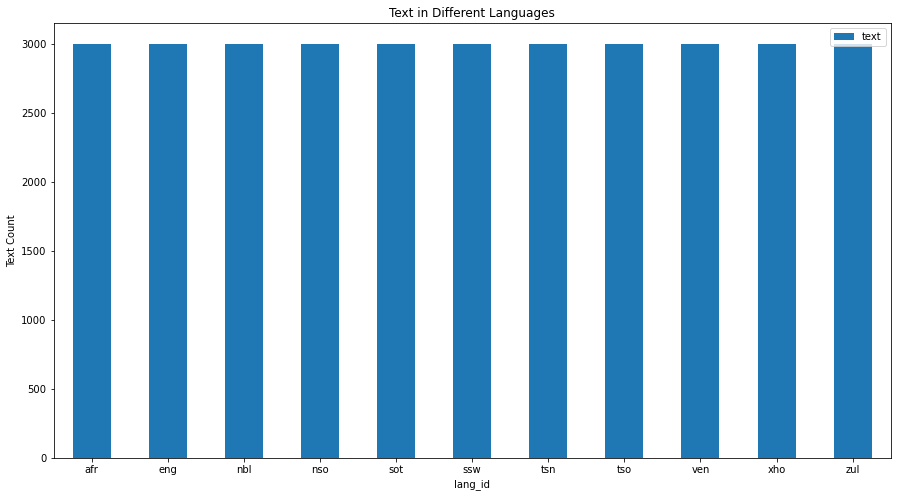

In [10]:
# Plot the graph
plt.rcParams['figure.figsize'] = (15, 8)
text_language.plot.bar(x = 'lang_id', y = 'text')
plt.title('Text in Different Languages')
plt.ylabel('Text Count')
plt.xticks(rotation = 0)
plt.show()

Also, one can investigate the frequent words used in the respective languages. This will be achieved using wordclouds.

In [11]:
# Get words used per language
afr = ' '.join([word for word in df_train['text'][df_train['lang_id'] == 'afr']])
eng = ' '.join([word for word in df_train['text'][df_train['lang_id'] == 'eng']])
nbl = ' '.join([word for word in df_train['text'][df_train['lang_id'] == 'nbl']])
nso = ' '.join([word for word in df_train['text'][df_train['lang_id'] == 'nso']])
sot = ' '.join([word for word in df_train['text'][df_train['lang_id'] == 'sot']])
ssw = ' '.join([word for word in df_train['text'][df_train['lang_id'] == 'ssw']])
tsn = ' '.join([word for word in df_train['text'][df_train['lang_id'] == 'tsn']])
tso = ' '.join([word for word in df_train['text'][df_train['lang_id'] == 'tso']])
ven = ' '.join([word for word in df_train['text'][df_train['lang_id'] == 'ven']])
xho = ' '.join([word for word in df_train['text'][df_train['lang_id'] == 'xho']])
zul = ' '.join([word for word in df_train['text'][df_train['lang_id'] == 'zul']])

### Common Afrikaans Words

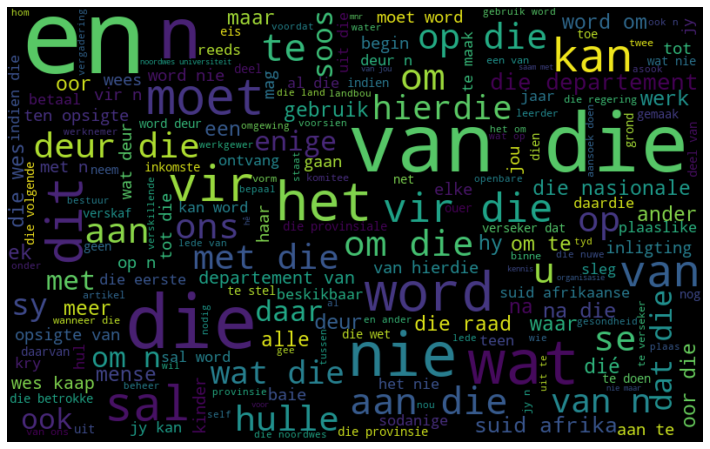

In [13]:
# Generate word cloud
wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 120).generate(afr)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Common English Words

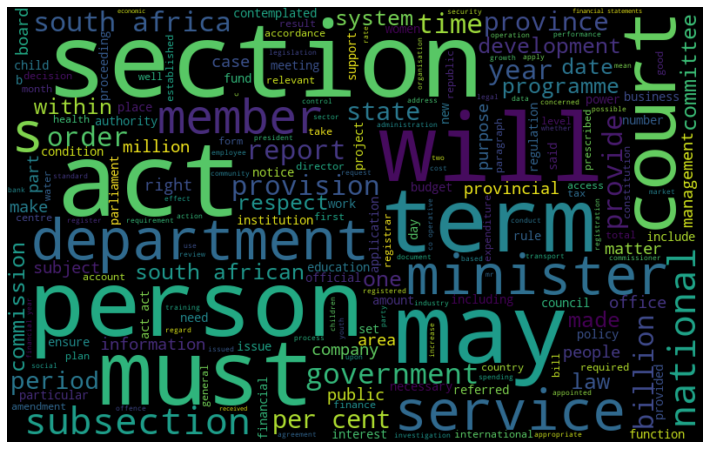

In [14]:
# Generate word cloud
wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 120).generate(eng)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Common isiNdebele Words

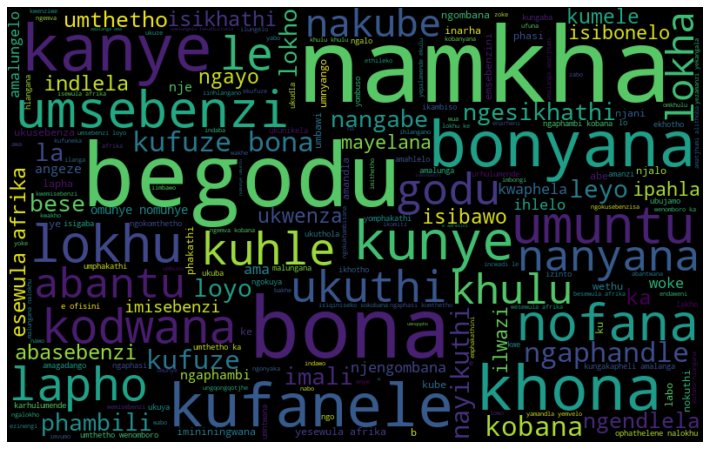

In [15]:
# Generate word cloud
wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 120).generate(nbl)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Common Sepedi Words

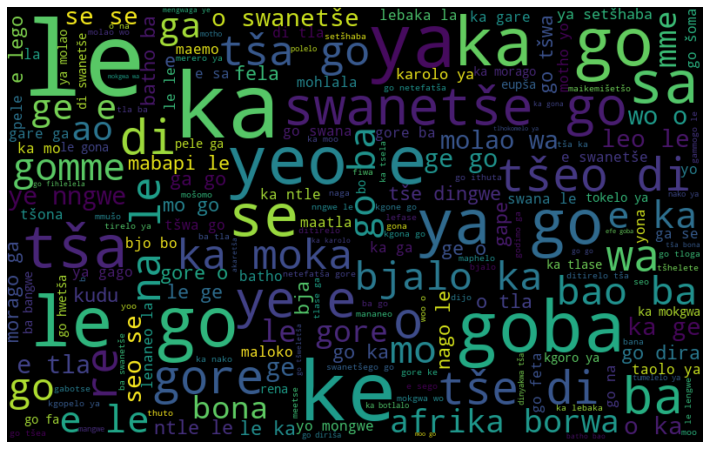

In [16]:
# Generate word cloud
wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 120).generate(nso)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Common Sesotho Words

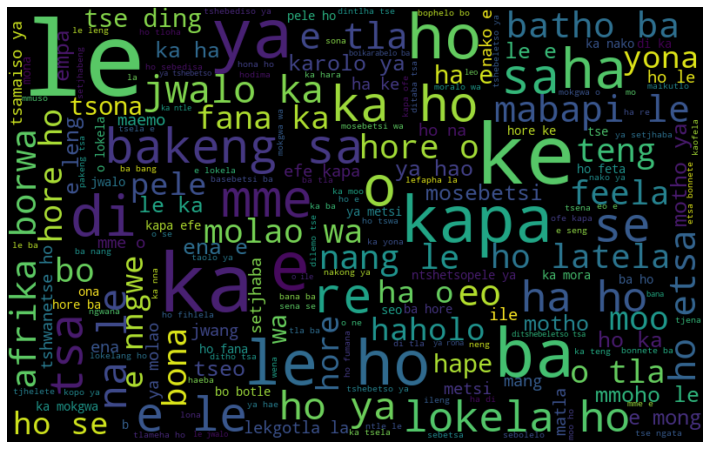

In [17]:
# Generate word cloud
wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 120).generate(sot)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Common siSwati Words

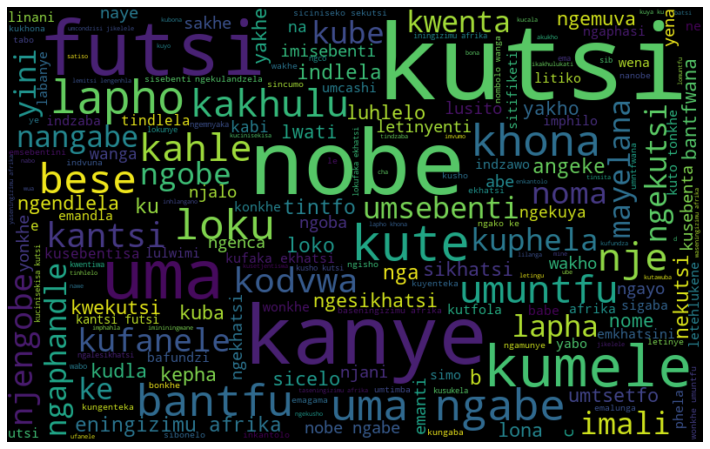

In [18]:
# Generate word cloud
wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 120).generate(ssw)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Common Setswana Words

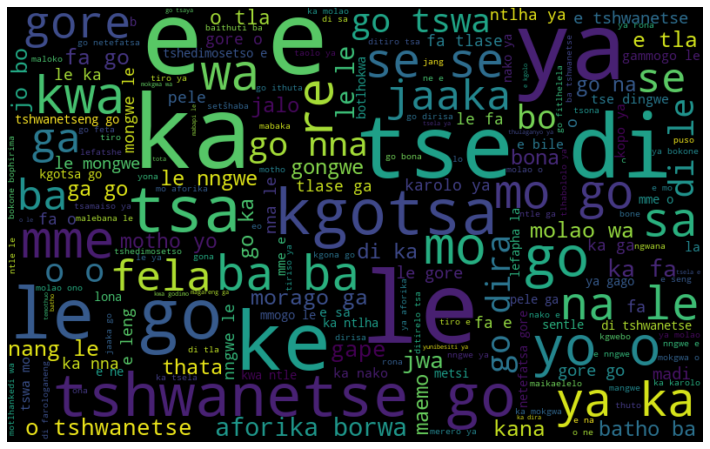

In [19]:
# Generate word cloud
wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 120).generate(tsn)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Common Xitsonga Words

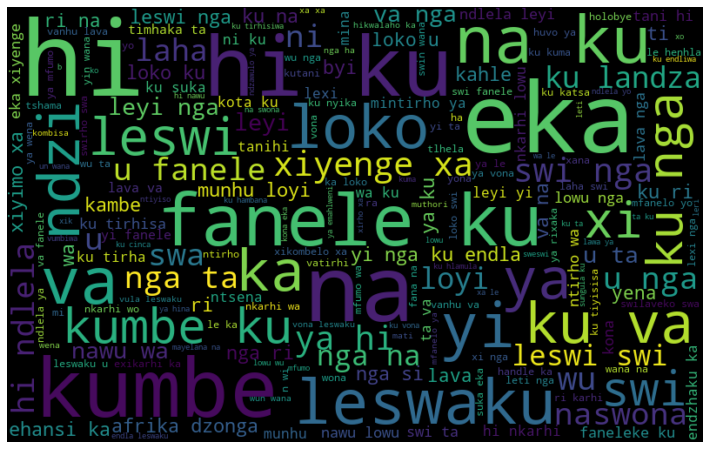

In [20]:
# Generate word cloud
wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 120).generate(tso)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Common Tshivenda Words

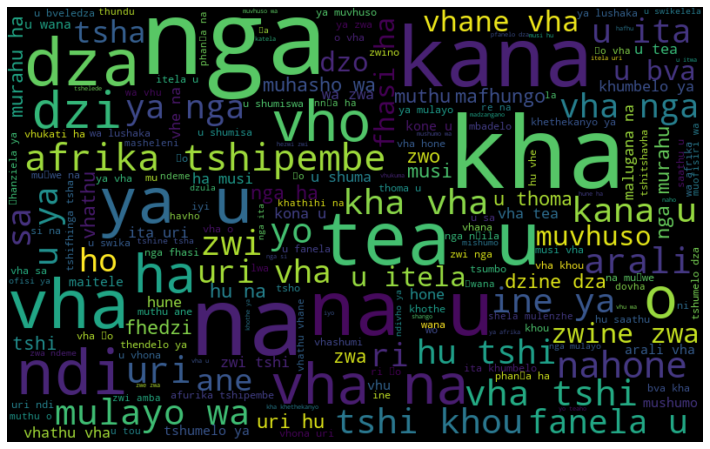

In [21]:
# Generate word cloud
wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 120).generate(ven)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Common isiXhosa Words

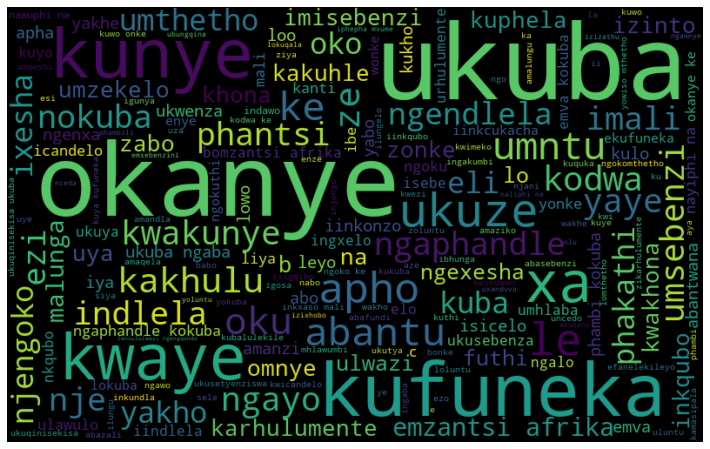

In [22]:
# Generate word cloud
wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 120).generate(xho)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Common isiZulu Words

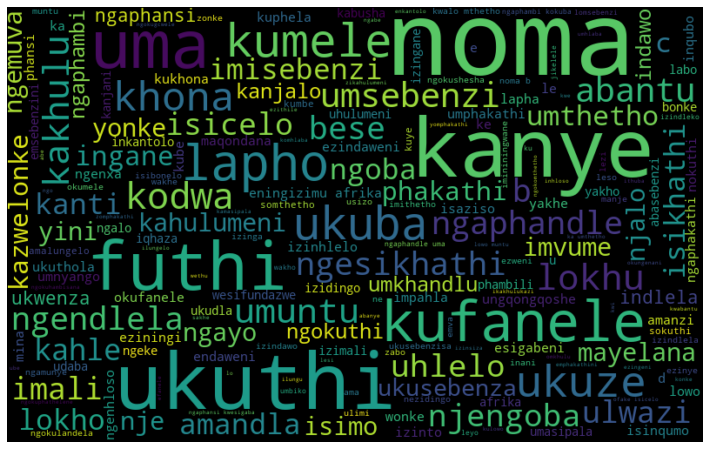

In [23]:
# Generate word cloud
wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 120).generate(zul)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Observation

From the word clouds, some words such as `kanye` appear in more than one language: isiZulu and siSwati, and `le` in isiNdebele, Sepedi, Sesotho, and Setswana.

However, most of the other common words are unique to each language.

## 4. Data Cleaning and Preprocessing

First, the text shall be converted to lower case and any punctuation and numbers be removed.

### Data Cleaning

In [29]:
# Function to clean the text
def clean_data(df, column):
    #Change to lower case
    print('Changing to lower case...')
    df[column] = df[column].str.lower()
    
    # Remove digits
    print('Removing digits...')
    df[column] = df[column].replace(to_replace = r'[0-9]', value = '', regex = True)
    
    # Remove punctuation
    print('Removing punctuation...')
    df[column] = df[column].replace(to_replace = r'[^\w\s]+', value = r'', regex = True)
    
    return df[column]

In [30]:
# Clean the train dataset
df_train['text'] = clean_data(df_train, 'text')

Changing to lower case...
Removing digits...
Removing punctuation...


In [31]:
# Clean the holdout dataset
df_test['text'] = clean_data(df_test, 'text')

Changing to lower case...
Removing digits...
Removing punctuation...


#### Confirm

In [32]:
# Confirm train dataset cleaned successfully
df_train.head()

lang_id                                               text
0     xho  umgaqosiseko wenza amalungiselelo kumaziko axh...
1     xho  idha iya kuba nobulumko bokubeka umsebenzi nap...
2     eng  the province of kwazulunatal department of tra...
3     nso  o netefatša gore o ba file dilo ka moka tše le...
4     ven  khomishini ya ndinganyiso ya mbeu yo ewa maana...

The values in the `text` column are in lower case and there are no punctuation marks.

### Separate Features and Target

In [33]:
# Get features and target
X = df_train['text']
y = df_train['lang_id']

### Label Encode the Target

Since `lang_id` datatype is **object**, it will be label encoded to convert it to a numerical format.

In [35]:
# Label encode lang_id
le = LabelEncoder()
y = le.fit_transform(y)

### Perform Train / Test Split

The train dataset will be split into a training set (80%) and a test set(20%). A random state value will be set to ensure reproducibility.

In [37]:
# Perform the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Perform Vectorization

The `TF-IDF Vectorizer` will be used because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words unlike the `Count Vectorizer`.

In [39]:
# Instantiate the Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform on it the training features
tfidf_vectorizer.fit(X_train)
X_train_features = tfidf_vectorizer.transform(X_train)

# Transform the test features to sparse matrix
X_test_features = tfidf_vectorizer.transform(X_test)

# Transform the holdout text
df_test_text = df_test['text']
df_test_features = tfidf_vectorizer.transform(df_test_text)

Confirm that the features have been generated successfully.

In [40]:
# Feaures generated
X_train_features.shape

(26400, 127012)

The training dataset has **26,400** records, and **127,012** features.

## 5. Modeling

The following models will be evaluated:
- Logistic Regression
- K Nearest Neighbours
- Naive Bayes
- Random Forest
- AdaBoost

In [50]:
# The model names
model_names = ['Logistic Regression', 'Nearest Neighbours', 'Naive Bayes', 'Random Forest', 'AdaBoost']

In [56]:
# Initialize classifiers
classifiers = [
    LogisticRegression(multi_class='ovr'),
    KNeighborsClassifier(50),
    MultinomialNB(),
    RandomForestClassifier(max_depth=5, n_estimators=50),
    AdaBoostClassifier()
]

The models will be trained and validated.

In [60]:
results = []

models = {}
confusion = {}
class_report = {}


for name, clf in zip(model_names, classifiers):
    start_time=time.time()
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train_features, y_train)
    
    print ('... predicting')
    y_pred = clf.predict(X_train_features)   
    y_pred_test = clf.predict(X_test_features)
    
    print ('... scoring')
    accuracy  = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred, average = 'weighted')
    recall    = metrics.recall_score(y_train, y_pred, average = 'weighted')
    
    f1        = metrics.f1_score(y_train, y_pred, average = 'weighted')    
    f1_test   = metrics.f1_score(y_test, y_pred_test, average = 'weighted')
    
    
    
    # Save the results to dictionaries
    models[name] = clf    
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_train, y_pred)
    
    results.append([name, accuracy, precision, recall, f1, f1_test, run_time.best])
    
    end_time=time.time()
    print("Time Taken: ",end_time-start_time)

    
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

print ('... All done!')

Fitting Logistic Regression model...
... predicting
... scoring
Time Taken:  142.39785718917847
Fitting Nearest Neighbours model...
... predicting
... scoring
Time Taken:  36.44004416465759
Fitting Naive Bayes model...
... predicting
... scoring
Time Taken:  7.365438461303711
Fitting Random Forest model...
... predicting
... scoring
Time Taken:  5.403069972991943
Fitting AdaBoost model...
... predicting
... scoring
Time Taken:  135.168799161911
... All done!


A look at the outcome.

In [62]:
# Order by the f1 test metric
results.sort_values('F1 Test', ascending=False)

Accuracy  Precision    Recall  F1 Train   F1 Test  \
Classifier                                                               
Naive Bayes          0.999697   0.999698  0.999697  0.999697  0.998485   
Logistic Regression  0.999167   0.999168  0.999167  0.999167  0.993939   
Nearest Neighbours   0.987197   0.987252  0.987197  0.987172  0.984950   
Random Forest        0.852235   0.880396  0.852235  0.853292  0.848528   
AdaBoost             0.490417   0.579160  0.490417  0.424156  0.435917   

                     Train Time  
Classifier                       
Naive Bayes            0.081771  
Logistic Regression   16.314534  
Nearest Neighbours     0.007959  
Random Forest          0.575347  
AdaBoost              16.268151

View the results graphically.

<AxesSubplot:xlabel='Classifier'>

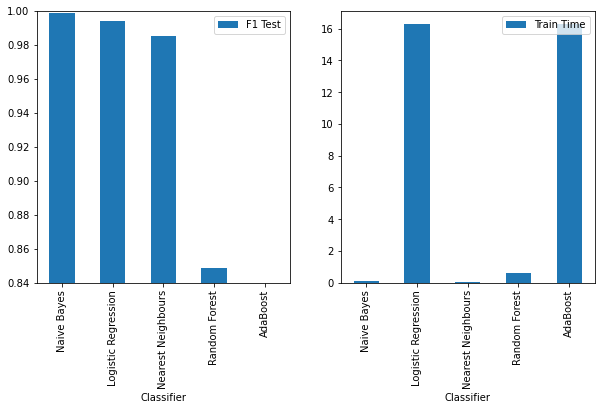

In [64]:
# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
results.sort_values('F1 Train', ascending=False, inplace=True)
results.plot(y=['F1 Test'], kind='bar', ax=ax[0], xlim=[0,1.1], ylim=[0.84,1])
results.plot(y='Train Time', kind='bar', ax=ax[1])

### Generate predictions from the top 3 Performing Models

In [69]:
# Top Model Names
top_model_names = ['Naive_Bayes', 'Logistic_Regression', 'Nearest_Neighbours']

# Top classifiers
top_classifiers = [
    MultinomialNB(),
    LogisticRegression(multi_class='ovr'),
    KNeighborsClassifier(50),
]

# Make predictions
for name, clf in zip(top_model_names, top_classifiers):
    clf.fit(X_train_features, y_train)
    y_hold_pred = clf.predict(df_test_features)
    
    # Decode Predictions
    y_hold_pred_decoded = le.inverse_transform(y_hold_pred)
    
    # Store predictions in a dataframe
    language = pd.DataFrame(y_hold_pred_decoded, columns = ['lang_id'])
    
    # Get index as a dataframe
    index = pd.DataFrame({'index': df_test['index']})
    
    # Combine index and language
    submission = index.join(language)
    
    # Write results to csv file
    file_name = name + '.csv'
    submission.to_csv(file_name, index = False)

## References

- [Language Detection Using Natural Language Processing](https://www.analyticsvidhya.com/blog/2021/03/language-detection-using-natural-language-processing/)
- [Language Detection using NLP](https://www.kaggle.com/code/basilb2s/language-detection-using-nlp)
- [Count Vectorizer vs TFIDF Vectorizer | Natural Language Processing](https://www.linkedin.com/pulse/count-vectorizers-vs-tfidf-natural-language-processing-sheel-saket/)